<a href="https://colab.research.google.com/github/deji4things2000/mlpro/blob/master/image%20identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



Fine-tune Vision Transformers for **anything** using images found on the web.

In [ ]:
%%capture

! pip install transformers pytorch-lightning --quiet
! sudo apt -qq install git-lfs
! git config --global credential.helper store
! nvidia-smi

In [ ]:
import requests
import math
import matplotlib.pyplot as plt
import shutil
from getpass import getpass
from PIL import Image, UnidentifiedImageError
from requests.exceptions import HTTPError
from io import BytesIO
from pathlib import Path
import torch
import pytorch_lightning as pl
from huggingface_hub import HfApi, HfFolder, Repository, notebook_login
from torch.utils.data import DataLoader
from torchmetrics import Accuracy
from torchvision.datasets import ImageFolder
from transformers import ViTFeatureExtractor, ViTForImageClassification

## Defining the search terms



In [ ]:
term_1 = "Lagos, Nigeria" #@param {type:"string"}
term_2 = "Dublin, Ireland" #@param {type:"string"}
term_3 = "Oslo, New Zealand" #@param {type:"string"}
term_4 = "" #@param {type:"string"}
term_5 = "" #@param {type:"string"}

search_terms = sorted([
    term_1,
    term_2,
    term_3,
    term_4,
    term_5
])

search_terms = [x for x in search_terms if x.strip() != '']

## Get Images From The Web

Here, I loop over selected search terms and collect ~150 related images for each.

In [ ]:
#!huggingface-cli login
SEARCH_URL = "https://serpapi.com/search?engine=bing_images"
def get_image_urls_by_term(search_term: str, count=150):
    params  = {"q": search_term, "engine":"bing_images", "api_key": "d24449779203430a0f29b208569ca9543025710f85ea2122c1b1c51c959bff1b", "photo": "photo", "license":"Type-Any", "outout": "JSON", "count": count}
    response = requests.get(SEARCH_URL, params=params)
    response.raise_for_status()
    #image_urls = [img['thumbnail'] for img in response.json()["images_results"]]
    try:
      image_urls = [img["thumbnail"] for img in response.json()["images_results"]]
    except KeyError:
      image_urls = []
    return image_urls


def gen_images_from_urls(urls):
    num_skipped = 0
    for url in urls:
        response = requests.get(url)
        if not response.status_code == 200:
            num_skipped += 1
        try:
            img = Image.open(BytesIO(response.content))
            yield img
        except UnidentifiedImageError:
            num_skipped +=1

    print(f"Retrieved {len(urls) - num_skipped} images. Skipped {num_skipped}.")


def urls_to_image_folder(urls, save_directory):
    for i, image in enumerate(gen_images_from_urls(urls)):
        image.save(save_directory / f'{i}.jpg')

In [ ]:
data_dir = Path('images')

if data_dir.exists():
    shutil.rmtree(data_dir)

for search_term in search_terms:
    search_term_dir = data_dir / search_term
    search_term_dir.mkdir(exist_ok=True, parents=True)
    urls = get_image_urls_by_term(search_term)
    print(f"Saving images of {search_term} to {str(search_term_dir)}...")
    urls_to_image_folder(urls, search_term_dir)

Saving images of Dublin, Ireland to images/Dublin, Ireland...
Retrieved 35 images. Skipped 0.
Saving images of Lagos, Nigeria to images/Lagos, Nigeria...
Retrieved 35 images. Skipped 0.
Saving images of Oslo, New Zealand to images/Oslo, New Zealand...
Retrieved 35 images. Skipped 0.


## Init Dataset and Split into Training and Validation Sets


In [ ]:
ds = ImageFolder(data_dir)
indices = torch.randperm(len(ds)).tolist()
n_val = math.floor(len(indices) * .15)
train_ds = torch.utils.data.Subset(ds, indices[:-n_val])
val_ds = torch.utils.data.Subset(ds, indices[-n_val:])

## Show Some Examples

The image search API should work fine

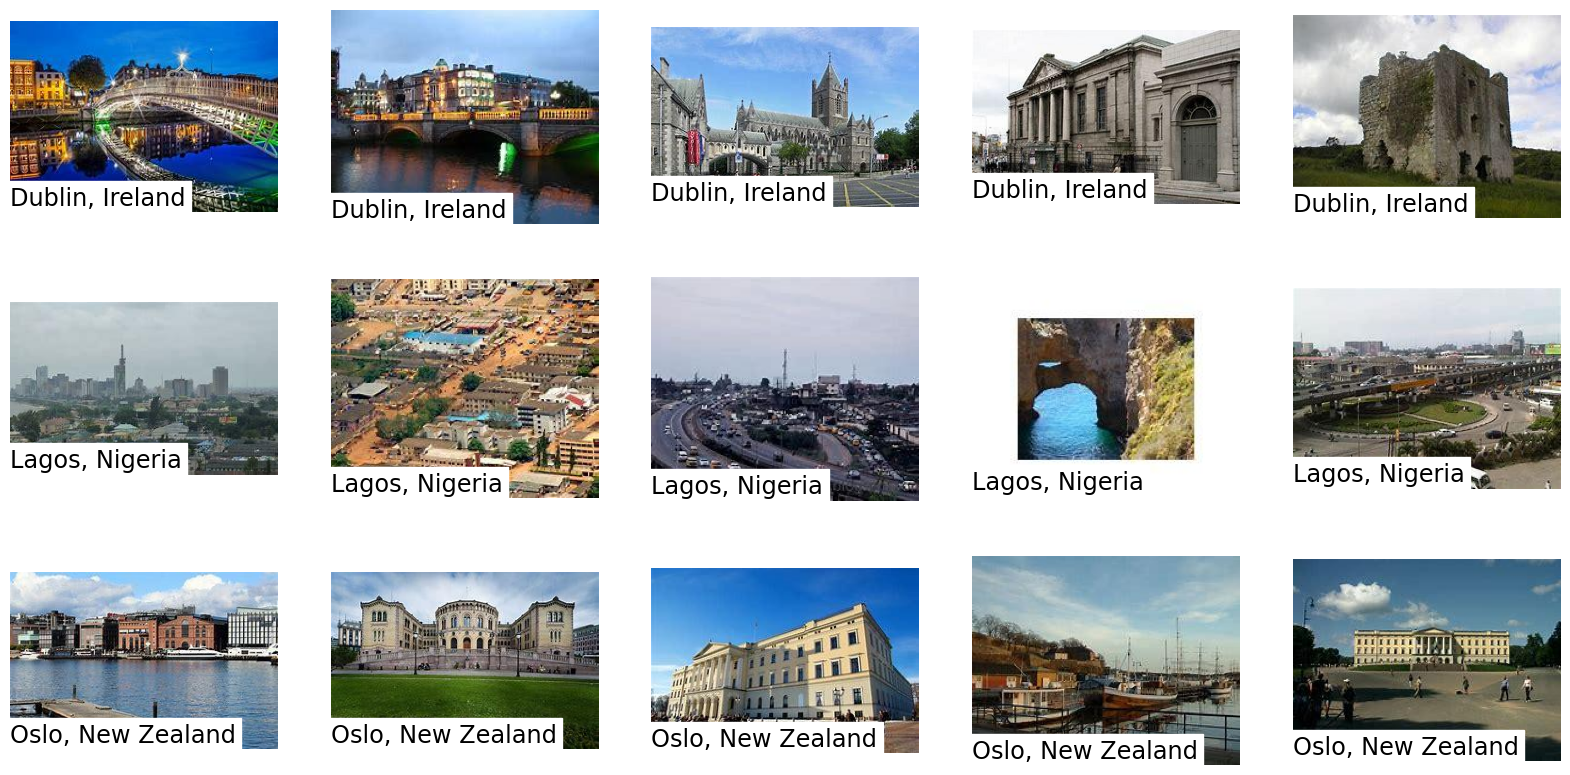

In [ ]:
plt.figure(figsize=(20,10))
num_examples_per_class = 5
i = 1
for class_idx, class_name in enumerate(ds.classes):
    folder = ds.root / class_name
    for image_idx, image_path in enumerate(sorted(folder.glob('*'))):
        if image_path.suffix in ds.extensions:
            image = Image.open(image_path)
            plt.subplot(len(ds.classes), num_examples_per_class, i)
            ax = plt.gca()
            ax.set_title(
                class_name,
                size='xx-large',
                pad=5,
                loc='left',
                y=0,
                backgroundcolor='white'
            )
            ax.axis('off')
            plt.imshow(image)
            i += 1

            if image_idx + 1 == num_examples_per_class:
                break

## Preparing Labels for Model's Config

By adding `label2id` + `id2label` to our model's config, we'll get friendlier labels in the inference API.

In [ ]:
label2id = {}
id2label = {}

for i, class_name in enumerate(ds.classes):
    label2id[class_name] = str(i)
    id2label[str(i)] = class_name

## Image Classification Collator

To apply the transforms to images, I used a custom collator class. It can be initialized using an instance of `ViTFeatureExtractor` and pass the collator instance to `torch.utils.data.DataLoader`'s `collate_fn` kwarg.

In [ ]:
class ImageClassificationCollator:
    def __init__(self, feature_extractor):
        self.feature_extractor = feature_extractor

    def __call__(self, batch):
        encodings = self.feature_extractor([x[0] for x in batch], return_tensors='pt')
        encodings['labels'] = torch.tensor([x[1] for x in batch], dtype=torch.long)
        return encodings

## Init Feature Extractor, Model, Data Loaders


In [ ]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=len(label2id),
    label2id=label2id,
    id2label=id2label
)
collator = ImageClassificationCollator(feature_extractor)
train_loader = DataLoader(train_ds, batch_size=8, collate_fn=collator, num_workers=2, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8, collate_fn=collator, num_workers=2)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Training

[PyTorch Lightning](https://pytorchlightning.ai/) is used to fine-tune the model.

In [ ]:
class Classifier(pl.LightningModule):

    def __init__(self, model, lr: float = 2e-5, **kwargs):
        super().__init__()
        self.save_hyperparameters('lr', *list(kwargs))
        self.model = model
        self.forward = self.model.forward
        self.val_acc = Accuracy(
            task='multiclass' if model.config.num_labels > 2 else 'binary',
            num_classes=model.config.num_labels
        )

    def training_step(self, batch, batch_idx):
        outputs = self(**batch)
        self.log(f"train_loss", outputs.loss)
        return outputs.loss

    def validation_step(self, batch, batch_idx):
        outputs = self(**batch)
        self.log(f"val_loss", outputs.loss)
        acc = self.val_acc(outputs.logits.argmax(1), batch['labels'])
        self.log(f"val_acc", acc, prog_bar=True)
        return outputs.loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

In [ ]:
pl.seed_everything(42)
classifier = Classifier(model, lr=2e-5)
trainer = pl.Trainer(accelerator='gpu', devices=1, precision=16, max_epochs=4)
trainer.fit(classifier, train_loader, val_loader)

INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type                      | Params
------------------------------------------------------
0 | model   | ViTForImageClassification | 85.8 M
1 | val_acc | MulticlassAccuracy        | 0     
------------------------------------------------------
85.8 M    Trainable params
0         Non-trainable params
85.8 M    Total params
343.204   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=4` reached.


#Verification to ensure it is working

In [ ]:
val_batch = next(iter(val_loader))
outputs = model(**val_batch)
print('Preds: ', outputs.logits.softmax(1).argmax(1))
print('Labels:', val_batch['labels'])

Preds:  tensor([0, 0, 0, 2, 1, 2, 2, 2])
Labels: tensor([0, 0, 0, 0, 1, 2, 2, 2])
